# Kaggle Project - Breast Cancer Wisconsin (Diagnostic) Data Set
# Part 3 - Alternative Model Approach

## Recap:
**Part 2** of this capstone project reproduced the results of classificaiton model described in the 1994 research paper <em>[Breast Cancer Diagnosis and Prognosis via Linear Programming](https://www.semanticscholar.org/paper/Breast-Cancer-Diagnosis-and-Prognosis-Via-Linear-Mangasarian-Street/3721bb14b16e866115c906336e9d70db096c05b9)</em> published/revised by Olvi L. Mangasarian, W. Nick Street & William H. Wolberg. The **[Support Vector Machine](https://en.wikipedia.org/wiki/Support-vector_machine)** model is able to achieve the same cross-validation accuracy score of 97.5% the same selected features including `extreme area`, `extreme smoothness`, and `mean texture`. The best accuracy was achieved through `GridSearch` over a range of `C` and `gamma`. Note the original paper achieve its best score using a linear plane while `SVM` achieved using non-linear kernel function, radius basis function, (`rbf`) therefore the algorithms are different.


## Overview:
**Part 3** of this project will try to further improve the model through feature extraction and a variety of algorithms. 

### Features:
As mention in **Part 1**, total 30 features were computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. `Feature elemination` (by selecting a subset) and `feature extraction` (through [principal component anaysis](https://en.wikipedia.org/wiki/Principal_component_analysis) or `PCA`) are two widely used technique to prevent overfitting the model. **Part 2** as well as the original paper used `feature elimination` by chosing the three that best predicts the outcome. In this section, `feature extraction` approach is evaluated. 

**Review of PCA**

Principal component analysis is a method of dimensionality reduction that identifies important relationships in our data (with `covariance`), transforms the existing data based on these relationships (with `eigenvector`), and then quantifies the importance of these relationships (with `eigenvalue`) eiso we can keep the most important relationships and drop the others!

**Why does PCA apply here**

The 30 features of the cell nuclies are consisted of 3 measures (mean, standard error, and worst) for each of the 10 features. Therefore the measures for the same features are expected to be highly correlated (e.g., the mean radius and worst radius). In addition, there are correlations among features (e.g., radius, perimeter, and area).  `PCA` is the proper technique to address this [multicollinearity problem](https://en.wikipedia.org/wiki/Multicollinearity).

**<span style="color:blue">Pros</span> & <span style="color:red">Cons</span> of PCA**

+ <span style="color:blue">Reduce the number of dimensions but keep all the original variables into consideration (no need to delete any original variables).</span>
+ <span style="color:blue">The new variables are independent of one another. Good for linear models.</span>
- <span style="color:red">The new independent variables are less interpretable.</span>

### Algorithms:
**Part 3** evaluates the following models:
1. [Logistic regression](#4.1---Logistic-Regression)
2. [K-nearest neighbors](#4.2---KNN)
3. [Random Forest](#4.3---Random-Forest)
4. [Adaboost](#4.4---Adaboost)
5. [Support Vector Machine](#4.5---Support-Vector-Machine)
6. [Neuro Network](#4.6---Neural-Network)

### Conclusion

**The Results**

**Metric**|**Paper**|**LR**|**KNN**|**RF**|**AB**|**SVC**|**NN**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
CV ACC|97.50%|98.10%|96.70%|92.30%|95.40%|97.90%|98.60%
ID 297|0.40%|14.00%|14.30%|23.90%|51.30%|0.60%|60.50%

**Summary**
1. Neural Network with PCA produces the best cross validation scores.
2. Models including linear regression, support vector machine, and neural network with PCA (with all features) outperform the original model based on cross validation. However, compared to feature elimination (the original paper), the feature extraction approach losts the interpretability of the importance of features.
3. Understand the features and model the features smartly provide great balance of the model results and inference. 

### <span style="color: red">IMPORTANT!<span>
    
<span style="color: red">Cross-validation is a way of estimating the generalisation performance of a process for building a model. There, however, is a common mistake that the data is preprocessed (e.g., with StandardScaler and/or PCA) before fitting the GridSearchCV. This mistake would lead to biased cross-validation scores by underestimating the variance of the validation data. The solution is using **Pipeline** whenever any data preprocessor is needed. I published a [blog post on Towardsdatascience.com](https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc) that discusses this issue.<span>


## Step 1 - Import Libraries

In [1]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Algorithm libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import tensorflow as tf

# Model evaluation libraries
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, recall_score, precision_score, accuracy_score

%matplotlib inline
plt.style.use('default') # set the plot style

## Step 2 - Data Preparation

### 2.1 - Data Cleaning

In [2]:
# Import from data.csv
df = pd.read_csv('../data/data.csv')
df.drop(columns = 'Unnamed: 32', inplace=True)
df = pd.get_dummies(df, columns=['diagnosis'], drop_first=True)
class_count = pd.DataFrame(df["diagnosis_M"].value_counts())
print(f'df dimension: {df.shape}')
print(f'class summary: \n {pd.DataFrame(class_count).reset_index().rename(columns={"index":"class","diagnosis_M":"count"})}')
df.head()

df dimension: (569, 32)
class summary: 
    class  count
0      0    357
1      1    212


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_M
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### 2.2 - X and y

In [3]:
# Create X and y
X = df.iloc[:,1:-1]
y = df['diagnosis_M']

In [4]:
# Check X shape and first 2 rows
print(f'X shape: {X.shape}')
X.head(2)

X shape: (569, 30)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [5]:
# Check y shape and first 2 rows
print(f'y shape: {y.shape}')
y.head(2)

y shape: (569,)


0    1
1    1
Name: diagnosis_M, dtype: uint8

## Step 3 - Feature Extraction with PCA

### 3.1 Transform Xs to PCAs

The **heatmap** show correlations are 0 between any of the two different principal components, which confirms that the pricinpal components ('new variables') are othogonal to each other (e.g., independent of each other).

Note that the fit & tranform of StandardScaler and PCA in this subsection are for the determination of number of principal components only. The `StandardScaler()` and `PCA()` are refit for each model discussed in **Step 4** due to the process flow of GridSearchCV (discussed in **Step 4**).

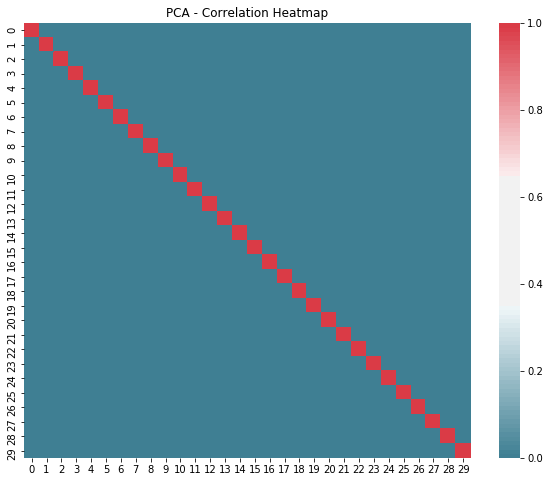

In [6]:
# Instantiate StandardScaler
sc = StandardScaler()
# Instantiate PCA
pca = PCA()
# Scale Xs
X_sc = sc.fit_transform(X)
# Transform Xs to PCAs
Z_sc = pca.fit_transform(X_sc)

# Plot heatmap for correlations
# Heatmap color scheme
heatmap_scheme = sns.diverging_palette(220, 10, sep=80, n=100)
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(Z_sc).corr(), cmap=heatmap_scheme)
plt.title('PCA - Correlation Heatmap');

### 3.2 Determine the Number of Principal Components for Modeling

Based on the **Component vs. Variance Explained** figure above, 10 principal components explain 95%+ of the variation. The number of component for **Step 4** is set to be 10.

In [7]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp,3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp,3)}')

Explained variance (first 20 components): [0.443 0.19  0.094 0.066 0.055 0.04  0.023 0.016 0.014 0.012 0.01  0.009
 0.008 0.005 0.003 0.003 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.001 0.    0.    0.    0.    0.   ]

Cumulative explained variance (first 20 components): [0.443 0.632 0.726 0.792 0.847 0.888 0.91  0.926 0.94  0.952 0.961 0.97
 0.978 0.983 0.986 0.989 0.991 0.993 0.995 0.996 0.997 0.997 0.998 0.999
 0.999 1.    1.    1.    1.    1.   ]


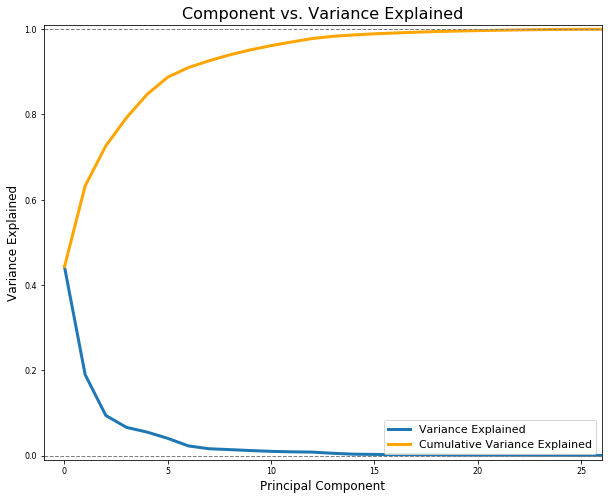

In [8]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(10,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,26])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=12)
plt.xlabel('Principal Component', fontsize=12)

# Make the tick labels bigger
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=16)
plt.legend(fontsize=11);

## Step 4 - Modeling

In [9]:
# Global variable
n_components = 10
# Results dictionaries
param, pred, pred_prob, results, accuracy, recall, precision, f1, cmf = \
{}, pd.DataFrame(), pd.DataFrame(), {}, {}, {}, {}, {}, {}
pred['true_y'] = y.values
pred_prob['true_y'] = y.values

### 4.1 - Logistic Regression

#### 4.1.1 - Model

In [10]:
# Model
model = 'lr'

# pipeline for transformers and estimator
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('lr', LogisticRegression())
])

# pipeline for transformers and estimator
param = {
    'lr__penalty': ['l1', 'l2'],    # l1 = LASSO, l2 = RIDGE
    'lr__C': np.logspace(-3, 3, 7), # inverse of regularization strength
    'lr__solver': ['liblinear']     # liblinear is good for small dataset and handle both L1 and L2 penalties.
}

# GridSearchCV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# Fit the model
search.fit(X, y)

# Results
param[model] = search.best_params_
pred[model] = search.predict(X)
pred_prob[model] = [i[1] for i in search.predict_proba(X)]
results[model] = search.cv_results_
accuracy[model] = round(search.best_score_*100, 1)
recall[model] = round(recall_score(y, pred[model])*100, 1)
precision[model] = round(precision_score(y, pred[model])*100, 1)
f1[model] = round(f1_score(y, pred[model])*100, 1)
print(f'The best parameters are: {param[model]}.') # best parameter
print(f'The best CV Arruacy score: {accuracy[model]}%.')
# print(f'The best train Recall score: {recall[model]}%.')
# print(f'The best train Precision score: {precision[model]}%.')
print(f'The best train F1 score: {f1[model]}%.')
pd.DataFrame(confusion_matrix(y, pred[model]), columns=['pred_N', 'pred_T'], index=['actual_N', 'actual_T'])

The best parameters are: {'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}.
The best CV Arruacy score: 98.1%.
The best train F1 score: 98.1%.


,pred_N,pred_T
actual_N,355,2
actual_T,6,206


#### 4.1.2 - Visualization

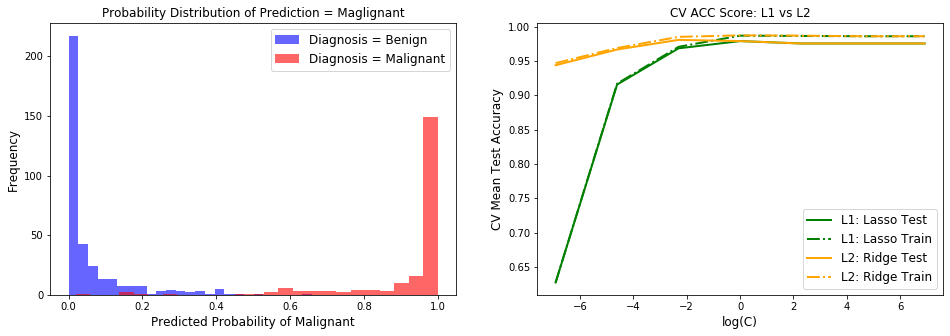

In [11]:
# Figure: Probability Distribution
def prob_density(pred_prob, model):
    plt.figure(figsize = (16,5))

    # Create two histograms of observations.
    plt.subplot(121)
    plt.hist(pred_prob[pred_prob['true_y'] == 0][model],
             bins=25,
             color='b',
             alpha = 0.6,
             label='Diagnosis = Benign')
    plt.hist(pred_prob[pred_prob['true_y'] == 1][model],
             bins=25,
             color='red',
             alpha = 0.6,
             label='Diagnosis = Malignant')

    # Label axes.
    plt.title('Probability Distribution of Prediction = Maglignant', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlabel('Predicted Probability of Malignant', fontsize=12)

    # Create legend.
    plt.legend(fontsize=12);

prob_density(pred_prob, model)
# -------------------------------------------------------------------------------

# Figure: CV ACC Score: L1 vs L2
plt.subplot(122)

# x value for the plot
C = np.log(results['lr']['param_lr__C'][::2].data.astype(float)) 

# Extract CV train and test scores
test_acc_l1 = results['lr']['mean_test_score'][::2]
train_acc_l1 = results['lr']['mean_train_score'][::2]
test_acc_l2 = results['lr']['mean_test_score'][1::2]
train_acc_l2 = results['lr']['mean_train_score'][1::2]

# Plot the figures
plt.plot(C, test_acc_l1, lw=2, color='green', linestyle='-', label='L1: Lasso Test')
plt.plot(C, train_acc_l1, lw=2, color='green', linestyle='-.', label='L1: Lasso Train')
plt.plot(C, test_acc_l2, lw=2, color='orange', linestyle='-', label='L2: Ridge Test')
plt.plot(C, train_acc_l2, lw=2, color='orange', linestyle='-.', label='L2: Ridge Train')

# Label axes.
plt.title('CV ACC Score: L1 vs L2', fontsize=12)
plt.ylabel('CV Mean Test Accuracy', fontsize=12)
plt.xlabel('log(C)', fontsize=12)

# Create legend.
plt.legend(fontsize=12, loc='lower right');

In [12]:
# Check the model output probability the top 5 misclassfied maglignant cells
pred_prob[pred_prob['true_y'] == 1].sort_values(by=model).head(5)

,true_y,lr
297,1,0.019186
135,1,0.140352
40,1,0.157566
73,1,0.213019
263,1,0.292573


The logistic regiression with 10 principal components increases the worst case misclassfied malignant cell from **0.4%** from Part 2 to **1.9%**. Adding additional information to the model helps with the learning. It is yet sufficient to correct the misclassificaiton. This prediction is also produced using a different algorithms.

### 4.2 - KNN

#### 4.2.1 Model

In [13]:
model = 'knn'

# Instantiate pipeline
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('knn', KNeighborsClassifier())
])

# Model parameters
param = {
#     'knn__n_neighbors': list(range(3, 21, 2)), # 1st run to determine the best model
#     'knn__weights': ['uniform', 'distance'],   # 1st run to determine the best model
#     'knn__p': [1, 2, 3, 4, 5]                  # 1st run to determine the best model
    'knn__n_neighbors': list(range(1, 40, 2)), # 2nd run to for visualization
    'knn__weights': ['uniform'] ,              # 2nd run based on the best model
    'knn__p': [1, 2]                           # 2nd run based on the best model
}

# Instantiate GridSearchCV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)


# Fit the model
search.fit(X, y)

# Results
param[model] = search.best_params_
pred[model] = search.predict(X)
pred_prob[model] = [i[1] for i in search.predict_proba(X)]
results[model] = search.cv_results_
accuracy[model] = round(search.best_score_*100, 1)
recall[model] = round(recall_score(y, pred[model])*100, 1)
precision[model] = round(precision_score(y, pred[model])*100, 1)
f1[model] = round(f1_score(y, pred[model])*100, 1)
print(f'The best parameters are: {param[model]}.') # best parameter
print(f'The best CV Arruacy score: {accuracy[model]}%.')
# print(f'The best train Recall score: {recall[model]}%.')
# print(f'The best train Precision score: {precision[model]}%.')
print(f'The best train F1 score: {f1[model]}%.')
pd.DataFrame(confusion_matrix(y, pred[model]), columns=['pred_N', 'pred_T'], index=['actual_N', 'actual_T'])

The best parameters are: {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}.
The best CV Arruacy score: 96.7%.
The best train F1 score: 96.6%.


,pred_N,pred_T
actual_N,356,1
actual_T,13,199


#### 4.2.2 Visualization

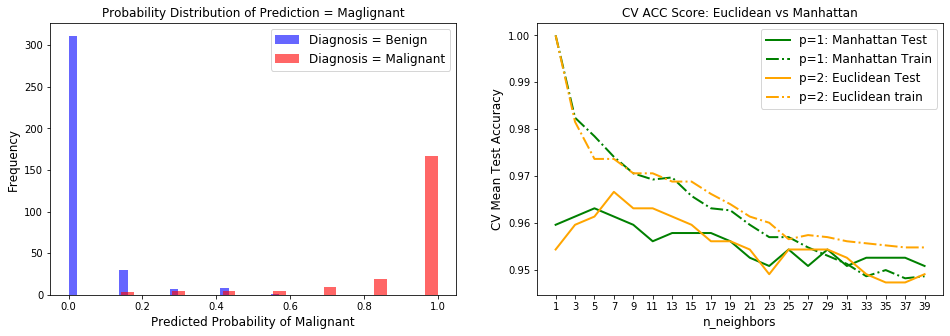

In [14]:
# Figure: Probability Distribution
prob_density(pred_prob, model)

# -------------------------------------------------------------------------------

plt.subplot(122)

# Create threshold values.
n_neighbors = results['knn']['param_knn__n_neighbors'][::2].data.astype(int)
test_acc_p1 = results['knn']['mean_test_score'][::2]
train_acc_p1 = results['knn']['mean_train_score'][::2]
test_acc_p2 = results['knn']['mean_test_score'][1::2]
train_acc_p2 = results['knn']['mean_train_score'][1::2]

plt.plot(n_neighbors, test_acc_p1, lw=2, color='green', linestyle='-', label='p=1: Manhattan Test')
plt.plot(n_neighbors, train_acc_p1, lw=2, color='green', linestyle='-.', label='p=1: Manhattan Train')
plt.plot(n_neighbors, test_acc_p2, lw=2, color='orange', linestyle='-', label='p=2: Euclidean Test')
plt.plot(n_neighbors, train_acc_p2, lw=2, color='orange', linestyle='-.', label='p=2: Euclidean train')

# Label axes.
plt.title('CV ACC Score: Euclidean vs Manhattan', fontsize=12)
plt.ylabel('CV Mean Test Accuracy', fontsize=12)
plt.xlabel('n_neighbors', fontsize=12)
plt.xticks(n_neighbors)

# Create legend.
plt.legend(fontsize=12);

In [15]:
# Check the model output probability the top 5 misclassfied maglignant cells
pred_prob[pred_prob['true_y'] == 1].sort_values(by=model).head(5)

,true_y,lr,knn
297,1,0.019186,0.142857
414,1,0.779411,0.142857
135,1,0.140352,0.142857
73,1,0.213019,0.285714
40,1,0.157566,0.285714


**Summary:** 
1. In terms of CV accuracy score, the KNN model perform worse than the logistic regression and the SVM model discussed in **Part 2**. 
2. The two power parameters for the Minkowski metric (i.e., Manhattan when p=1, Euclidean when p=2) behave similarly with Euclidean outperforms Manhattan slightly in both bias (best score) and variance (difference between test and train). Euclidean gives the best score when n_neighbors = 7 while Manhattan when n_neighbors = 5. However, because the scores varies in a very narrow window, these variation may be not meaningful.
3. In general, the rule of thumb is to choose **n_neighbors = sqrt(n)** where n is number of data, where it usually works very well. In this case, n_neighbors = sqrt(596) = 23.8 -> 25 (odd number). Based on the plot above, 25 gives good bias & variance balance.

### 4.3 - Random Forest

**Why PCA + Random Forest**: 

Random forest mitigates overfitting through its emsemble algorithm ([bagging/boostrap aggregation](https://en.wikipedia.org/wiki/Bootstrap_aggregating)) and further de-corelated the bagged trees through ([random subspace method](https://en.wikipedia.org/wiki/Random_subspace_method)) (use only subset of features for each boostrapped sample). However, presented in **Part 1**, most features are strongly correlated, which lowers the effectiveness of the random space method and makes the bootstrapped trees less independent. Using PCA will eliminate this problem.

Another reason for using PCA with random forest (not applicable here) is to prevent model overfit when the dataset has more features than samples. Using PCA reduces the number of features. 

Again, the tradeoff of applying PCA is giving up the capability of learning the importance of each orginal features. The importance of each principal component is alraedy known and ranked by PCA so method such as .predict_proba() of the random forest model can no longer provide useful information.


------

**Impact of Correlated Features to the Random Forest Model in General**:

Compared to logistic regression, random forest model, in general, takes less impact from collinearity to its model **results**. However, collinearity may affect the accuracy of data interpretation. For instance, the `radius` and `area` of the cell are highly correlated. Any of these correlated features can be used as the predictor. When radius is used, the importance of area is significantly reduced because the associated gini impurity has been removed from the `radius` split.  Though the model results will not be significantly affected, the model will report incorrect feature importance (e.g., radius is more important than area while actually they are close). 

#### 4.3.1 - Model

In [16]:
model = 'rf'

# Instantiate pipeline
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('rf', RandomForestClassifier(n_estimators=100, 
                                  max_features='auto', # sqft(features) for classification
                                                       # features/3 for regression
                                  random_state=42))
])

# Model parameters
param = {
#     'rf__max_depth': list(range(2, 10, 1)),             # 2, based on the best model from the 1st run
#     'rf__min_samples_leaf': list(range(30, 200, 10)) ,  # 100, based on the best model from the 1st run
#     'rf__class_weight': [None, 'balanced', 'balanced_subsample'], # None, based on the best model from the 1st run
#     'rf__oob_score': [False, True]                      # False, based on the best model from the 1st run
    'rf__class_weight': [None, 'balanced'],       
    'rf__min_samples_leaf': list(range(30, 160, 10)),                      
    'rf__oob_score': [False]                             
}

# Instantiate GridSearchCV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=0,
)


# Fit the model
search.fit(X, y)

# Results
param[model] = search.best_params_
pred[model] = search.predict(X)
pred_prob[model] = [i[1] for i in search.predict_proba(X)]
results[model] = search.cv_results_
accuracy[model] = round(search.best_score_*100, 1)
recall[model] = round(recall_score(y, pred[model])*100, 1)
precision[model] = round(precision_score(y, pred[model])*100, 1)
f1[model] = round(f1_score(y, pred[model])*100, 1)
print(f'The best parameters are: {param[model]}.') # best parameter
print(f'The best CV Arruacy score: {accuracy[model]}%.')
# print(f'The best train Recall score: {recall[model]}%.')
# print(f'The best train Precision score: {precision[model]}%.')
print(f'The best train F1 score: {f1[model]}%.')
pd.DataFrame(confusion_matrix(y, pred[model]), columns=['pred_N', 'pred_T'], index=['actual_N', 'actual_T'])

The best parameters are: {'rf__class_weight': None, 'rf__min_samples_leaf': 100, 'rf__oob_score': False}.
The best CV Arruacy score: 92.3%.
The best train F1 score: 89.5%.


/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



,pred_N,pred_T
actual_N,338,19
actual_T,25,187


In [17]:
# Check the model output probability the top 5 misclassfied maglignant cells
pred_prob[pred_prob['true_y'] == 1].sort_values(by='rf').head(5)

,true_y,lr,knn,rf
297,1,0.019186,0.142857,0.175779
135,1,0.140352,0.142857,0.238777
38,1,0.545895,0.428571,0.303666
73,1,0.213019,0.285714,0.321206
171,1,0.611144,0.714286,0.330833


#### 4.3.2 - Visualization

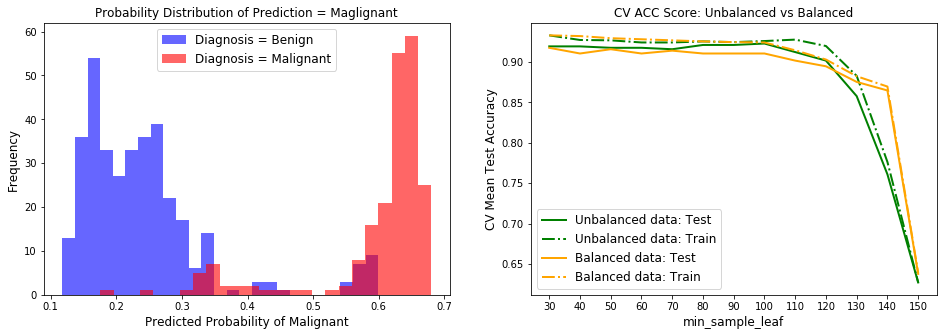

In [18]:
# Figure: Probability Distribution
prob_density(pred_prob, model)

# -------------------------------------------------------------------------------

plt.subplot(122)

# Create threshold values.
mid = int(len(results[model]['param_rf__class_weight'])/2)
min_sample_leaf = results[model]['param_rf__min_samples_leaf'][:mid].data.astype(int)
test_acc_unbalanced = results[model]['mean_test_score'][:mid]
train_acc_unbalanced = results[model]['mean_train_score'][:mid]
test_acc_balanced = results[model]['mean_test_score'][mid:]
train_acc_balanced = results[model]['mean_train_score'][mid:]

plt.plot(min_sample_leaf, test_acc_unbalanced, lw=2, color='green', linestyle='-', label='Unbalanced data: Test')
plt.plot(min_sample_leaf, train_acc_unbalanced, lw=2, color='green', linestyle='-.', label='Unbalanced data: Train')
plt.plot(min_sample_leaf, test_acc_balanced, lw=2, color='orange', linestyle='-', label='Balanced data: Test')
plt.plot(min_sample_leaf, train_acc_balanced, lw=2, color='orange', linestyle='-.', label='Balanced data: Train')

# Label axes.
plt.title('CV ACC Score: Unbalanced vs Balanced', fontsize=12)
plt.ylabel('CV Mean Test Accuracy', fontsize=12)
plt.xlabel('min_sample_leaf', fontsize=12)
plt.xticks(min_sample_leaf)

# Create legend.
plt.legend(fontsize=12);

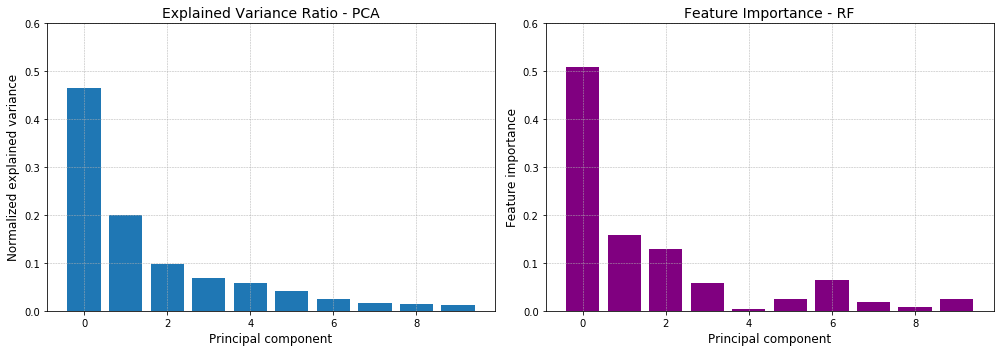

In [19]:
# Fit the best model
sc = StandardScaler()
pca = PCA(n_components=n_components)
rf = RandomForestClassifier(n_estimators=100, 
                            max_features='auto', 
                            random_state=42,
                            min_samples_leaf=100)
 
X_sc = sc.fit_transform(X)
X_pca = pca.fit_transform(X_sc)
best_rf = rf.fit(X_pca, y)

pca_ranking = pca.explained_variance_ratio_

pca_vs_rf = pd.DataFrame(columns=['pca_rank', 'rf_rank'])
pca_vs_rf['rf_rank'] = best_rf.feature_importances_
pca_vs_rf['pca_rank'] = pca_ranking/pca_ranking.sum()


plt.figure(figsize=[14, 5])
plt.subplot(121)
plt.bar(np.linspace(0, 9, 10), pca_vs_rf['pca_rank'])
plt.title('Explained Variance Ratio - PCA', fontsize=14)
plt.xlabel('Principal component', fontsize=12)
plt.ylabel('Normalized explained variance', fontsize=12)
plt.grid(which="major", linestyle='--', linewidth=0.5)
plt.ylim(0, 0.6)
plt.subplot(122)
plt.bar(np.linspace(0, 9, 10), pca_vs_rf['rf_rank'], color='purple')
plt.title('Feature Importance - RF', fontsize=14)
plt.xlabel('Principal component', fontsize=12)
plt.ylabel('Feature importance', fontsize=12)
plt.grid(which="major", linestyle='--', linewidth=0.5)
plt.ylim(0, 0.6)
plt.tight_layout();

### 4.4 - Adaboost

#### 4.4.1 - Model

In [20]:
model = 'ab'

# Instantiate pipeline
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('ab', AdaBoostClassifier(random_state=42))
])

# Model parameters
param = {
    'ab__n_estimators': [50, 100],             # 2, based on the best model from the 1st run
    'ab__learning_rate': np.logspace(-3, 2, 6) ,  # 100, based on the best model from the 1st run
#     'rf__class_weight': [None, 'balanced'],       
#     'rf__min_samples_leaf': list(range(30, 160, 10)),                      
#     'rf__oob_score': [False]                             
}

# Instantiate GridSearchCV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=0,
)


# Fit the model
search.fit(X, y)

# Results
param[model] = search.best_params_
pred[model] = search.predict(X)
pred_prob[model] = [i[1] for i in search.predict_proba(X)]
results[model] = search.cv_results_
accuracy[model] = round(search.best_score_*100, 1)
recall[model] = round(recall_score(y, pred[model])*100, 1)
precision[model] = round(precision_score(y, pred[model])*100, 1)
f1[model] = round(f1_score(y, pred[model])*100, 1)
print(f'The best parameters are: {param[model]}.') # best parameter
print(f'The best CV Arruacy score: {accuracy[model]}%.')
# print(f'The best train Recall score: {recall[model]}%.')
# print(f'The best train Precision score: {precision[model]}%.')
print(f'The best train F1 score: {f1[model]}%.')
pd.DataFrame(confusion_matrix(y, pred[model]), columns=['pred_N', 'pred_T'], index=['actual_N', 'actual_T'])

The best parameters are: {'ab__learning_rate': 1.0, 'ab__n_estimators': 50}.
The best CV Arruacy score: 95.4%.
The best train F1 score: 100.0%.


/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



,pred_N,pred_T
actual_N,357,0
actual_T,0,212


In [21]:
# Check the model output probability the top 5 misclassfied maglignant cells
pred_prob[pred_prob['true_y'] == 1].sort_values(by='ab').head(5)

,true_y,lr,knn,rf,ab
135,1,0.140352,0.142857,0.238777,0.512611
297,1,0.019186,0.142857,0.175779,0.515197
215,1,0.565481,0.714286,0.633529,0.517262
73,1,0.213019,0.285714,0.321206,0.519455
263,1,0.292573,0.428571,0.349715,0.521733


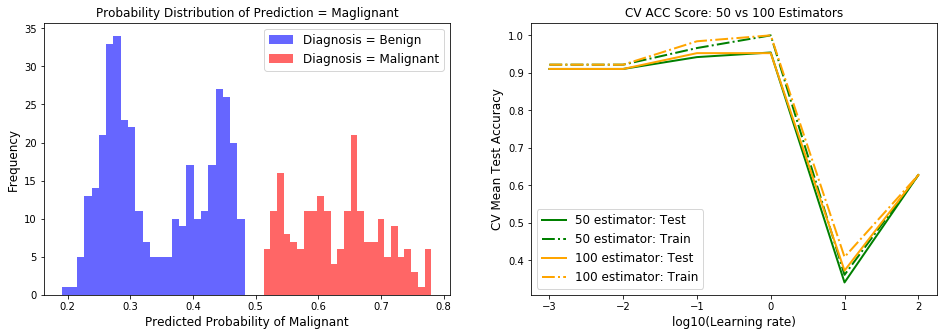

In [22]:
# Figure: Probability Distribution
prob_density(pred_prob, model)

# -------------------------------------------------------------------------------

plt.subplot(122)

# Create threshold values.
learning_rate = np.linspace(-3, 2, 6)
test_acc_unbalanced = results[model]['mean_test_score'][::2]
train_acc_unbalanced = results[model]['mean_train_score'][::2]
test_acc_balanced = results[model]['mean_test_score'][1::2]
train_acc_balanced = results[model]['mean_train_score'][1::2]

plt.plot(learning_rate, test_acc_unbalanced, lw=2, color='green', linestyle='-', label='50 estimator: Test')
plt.plot(learning_rate, train_acc_unbalanced, lw=2, color='green', linestyle='-.', label='50 estimator: Train')
plt.plot(learning_rate, test_acc_balanced, lw=2, color='orange', linestyle='-', label='100 estimator: Test')
plt.plot(learning_rate, train_acc_balanced, lw=2, color='orange', linestyle='-.', label='100 estimator: Train')

# Label axes.
plt.title('CV ACC Score: 50 vs 100 Estimators', fontsize=12)
plt.ylabel('CV Mean Test Accuracy', fontsize=12)
plt.xlabel('log10(Learning rate)', fontsize=12)
plt.xticks(learning_rate)

# Create legend.
plt.legend(fontsize=12);

### 4.5 - Support Vector Machine

#### 4.5.1 - Model

In [23]:
model = 'svc'

# Instantiate pipeline
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('svc', SVC(random_state=42, probability=True))
])

# Model parameters
param = {
    'svc__kernel': ['rbf'],
    'svc__C': np.logspace(-3, 3, 7),
    'svc__gamma': np.logspace(-3, 3, 7)                            
}

# Instantiate GridSearchCV
search = GridSearchCV(
    estimator=pipe,
    param_grid=param,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    verbose=0,
)


# Fit the model
search.fit(X, y)

# Results
param[model] = search.best_params_
pred[model] = search.predict(X)
pred_prob[model] = [i[1] for i in search.predict_proba(X)]
results[model] = search.cv_results_
accuracy[model] = round(search.best_score_*100, 1)
recall[model] = round(recall_score(y, pred[model])*100, 1)
precision[model] = round(precision_score(y, pred[model])*100, 1)
f1[model] = round(f1_score(y, pred[model])*100, 1)
print(f'The best parameters are: {param[model]}.') # best parameter
print(f'The best CV Arruacy score: {accuracy[model]}%.')
# print(f'The best train Recall score: {recall[model]}%.')
# print(f'The best train Precision score: {precision[model]}%.')
print(f'The best train F1 score: {f1[model]}%.')
pd.DataFrame(confusion_matrix(y, pred[model]), columns=['pred_N', 'pred_T'], index=['actual_N', 'actual_T'])

The best parameters are: {'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}.
The best CV Arruacy score: 97.9%.
The best train F1 score: 97.9%.


/Users/kaizhao/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



,pred_N,pred_T
actual_N,355,2
actual_T,7,205


In [ ]:
# Check the model output probability the top 5 misclassfied maglignant cells
pred_prob[pred_prob['true_y'] == 1].sort_values(by='svc').head(5)

,true_y,lr,knn,rf,ab,svc
297,1,0.019186,0.142857,0.175779,0.515197,0.005949
73,1,0.213019,0.285714,0.321206,0.519455,0.101549
135,1,0.140352,0.142857,0.238777,0.512611,0.112386
40,1,0.157566,0.285714,0.349839,0.525506,0.209047
215,1,0.565481,0.714286,0.633529,0.517262,0.378404


#### 4.5.2 - Visualization

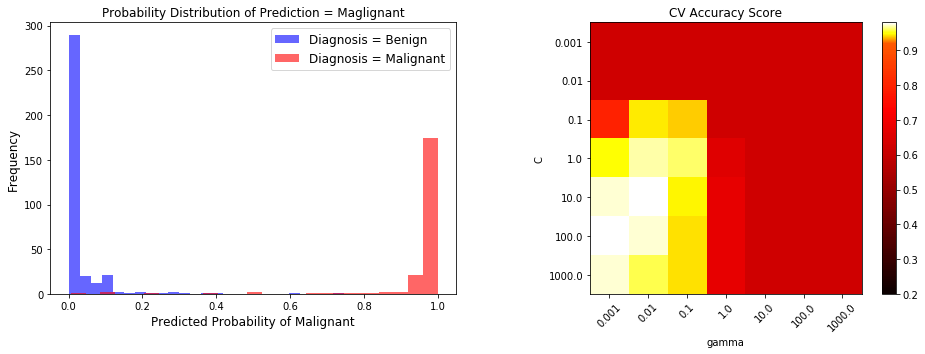

In [ ]:
# Figure: Probability Distribution
prob_density(pred_prob, model)

# -------------------------------------------------------------------------------


C = np.logspace(-3, 3, 7)
gamma = np.logspace(-3, 3, 7)
val_scores = search.cv_results_['mean_test_score'].reshape(len(C),len(gamma))

### The following code in this cell is from Sklearn documentary
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#rbf-svm-parameters

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.subplot(122)
plt.imshow(val_scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma)), gamma, rotation=45)
plt.yticks(np.arange(len(C)), C)
plt.title('CV Accuracy Score')
plt.show()

### 4.6 - Neural-Network

3 Dense layers + 2 dropout layers with dropout rate of 0.2.

#### 4.6.1 - Model

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Callback function: reduce the learning rate once the loss function improvement hits the plateau.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                 factor=0.3, 
                                                 patience=10, 
                                                 min_lr=0.0000001, 
                                                 verbose=1)
# Neural network layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

# Compile
model.compile( 
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['acc']
)

# Fit model
hist = model.fit(X_train, y_train,
                 validation_data=(X_test, y_test), 
                 epochs=200,
                 verbose=1,
                 callbacks=[reduce_lr])

W0904 14:14:11.425531 4468483520 deprecation.py:323] From /Users/kaizhao/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 426 samples, validate on 143 samples
Epoch 1/200
426/426 [==============================] - 0s 953us/sample - loss: 0.7948 - acc: 0.5023 - val_loss: 0.6731 - val_acc: 0.5944
Epoch 2/200
426/426 [==============================] - 0s 63us/sample - loss: 0.6962 - acc: 0.5751 - val_loss: 0.5900 - val_acc: 0.6853
Epoch 3/200
426/426 [==============================] - 0s 80us/sample - loss: 0.6256 - acc: 0.6667 - val_loss: 0.5265 - val_acc: 0.7343
Epoch 4/200
426/426 [==============================] - 0s 63us/sample - loss: 0.5754 - acc: 0.7089 - val_loss: 0.4780 - val_acc: 0.7972
Epoch 5/200
426/426 [==============================] - 0s 61us/sample - loss: 0.5066 - acc: 0.7676 - val_loss: 0.4352 - val_acc: 0.8322
Epoch 6/200
426/426 [==============================] - 0s 64us/sample - loss: 0.4603 - acc: 0.8146 - val_loss: 0.3982 - val_acc: 0.9021
Epoch 7/200
426/426 [==============================] - 0s 74us/sample - loss: 0.4443 - acc: 0.8169 - val_loss: 0.3653 - val_acc: 0.9161
E

426/426 [==============================] - 0s 73us/sample - loss: 0.0799 - acc: 0.9695 - val_loss: 0.0750 - val_acc: 0.9790
Epoch 61/200
426/426 [==============================] - 0s 73us/sample - loss: 0.0650 - acc: 0.9742 - val_loss: 0.0743 - val_acc: 0.9790
Epoch 62/200
426/426 [==============================] - 0s 59us/sample - loss: 0.0769 - acc: 0.9601 - val_loss: 0.0749 - val_acc: 0.9790
Epoch 63/200
426/426 [==============================] - 0s 55us/sample - loss: 0.0868 - acc: 0.9624 - val_loss: 0.0744 - val_acc: 0.9790
Epoch 64/200
426/426 [==============================] - 0s 65us/sample - loss: 0.0645 - acc: 0.9812 - val_loss: 0.0725 - val_acc: 0.9790
Epoch 65/200
426/426 [==============================] - 0s 69us/sample - loss: 0.0639 - acc: 0.9883 - val_loss: 0.0739 - val_acc: 0.9790
Epoch 66/200
426/426 [==============================] - 0s 58us/sample - loss: 0.0595 - acc: 0.9765 - val_loss: 0.0742 - val_acc: 0.9790
Epoch 67/200
426/426 [==============================] 

426/426 [==============================] - 0s 57us/sample - loss: 0.0460 - acc: 0.9883 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 119/200
426/426 [==============================] - 0s 54us/sample - loss: 0.0573 - acc: 0.9765 - val_loss: 0.0915 - val_acc: 0.9720
Epoch 120/200
426/426 [==============================] - 0s 56us/sample - loss: 0.0445 - acc: 0.9859 - val_loss: 0.0915 - val_acc: 0.9720
Epoch 121/200
 32/426 [=>............................] - ETA: 0s - loss: 0.1149 - acc: 0.9688
Epoch 00121: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
426/426 [==============================] - 0s 63us/sample - loss: 0.0520 - acc: 0.9883 - val_loss: 0.0915 - val_acc: 0.9790
Epoch 122/200
426/426 [==============================] - 0s 61us/sample - loss: 0.0508 - acc: 0.9765 - val_loss: 0.0915 - val_acc: 0.9720
Epoch 123/200
426/426 [==============================] - 0s 54us/sample - loss: 0.0572 - acc: 0.9765 - val_loss: 0.0917 - val_acc: 0.9720
Epoch 124/200
426/426 [===

Epoch 173/200
426/426 [==============================] - 0s 70us/sample - loss: 0.0409 - acc: 0.9859 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 174/200
 32/426 [=>............................] - ETA: 0s - loss: 0.0352 - acc: 1.0000
Epoch 00174: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
426/426 [==============================] - 0s 64us/sample - loss: 0.0602 - acc: 0.9836 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 175/200
426/426 [==============================] - 0s 48us/sample - loss: 0.0480 - acc: 0.9742 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 176/200
426/426 [==============================] - 0s 60us/sample - loss: 0.0454 - acc: 0.9812 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 177/200
426/426 [==============================] - 0s 54us/sample - loss: 0.0517 - acc: 0.9883 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 178/200
426/426 [==============================] - 0s 44us/sample - loss: 0.0475 - acc: 0.9859 - val_loss: 0.0918 - val_acc: 0.9790
Epoch 179/20

#### 4.6.2 - Visualization

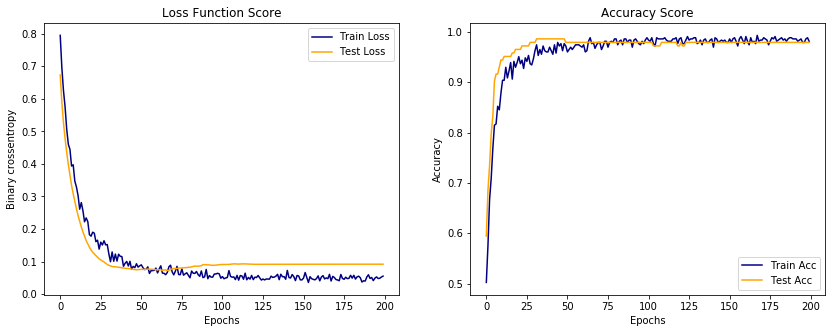

In [ ]:
train_loss = hist.history['loss']
test_loss = hist.history['val_loss']
train_acc = hist.history['acc']
test_acc = hist.history['val_acc']

plt.figure(figsize=(14, 5))

plt.subplot(121)
plt.plot(train_loss, label="Train Loss", color="navy")
plt.plot(test_loss, label="Test Loss", color="orange")
plt.title('Loss Function Score')
plt.xlabel('Epochs')
plt.ylabel('Binary crossentropy')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label="Train Acc", color="navy")
plt.plot(test_acc, label="Test Acc", color="orange")
plt.title('Accuracy Score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
model = 'nn'

X = StandardScaler().fit_transform(X)
X = PCA().fit_transform(X)

# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['acc'] > 0.9950:
            print('Acc achieved 99.5%')
            self.model.stop_training=True

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', 
                                                 factor=0.3, 
                                                 patience=10, 
                                                 min_lr=0.0000001, 
                                                 verbose=1)
callbacks=myCallback()

# Neural network layers
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=16, activation='relu', input_dim=X.shape[1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

# Compile
nn.compile( 
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['acc']
)

# Fit model
hist = nn.fit(X, y,
                 epochs=200,
                 verbose=1,
                 callbacks=[reduce_lr, callbacks])

Train on 569 samples
Epoch 1/200
569/569 [==============================] - 0s 498us/sample - loss: 1.0508 - acc: 0.2408
Epoch 2/200
569/569 [==============================] - 0s 50us/sample - loss: 0.8710 - acc: 0.3357
Epoch 3/200
569/569 [==============================] - 0s 60us/sample - loss: 0.8119 - acc: 0.3427
Epoch 4/200
569/569 [==============================] - 0s 84us/sample - loss: 0.7219 - acc: 0.4446
Epoch 5/200
569/569 [==============================] - 0s 74us/sample - loss: 0.6880 - acc: 0.4868
Epoch 6/200
569/569 [==============================] - 0s 59us/sample - loss: 0.6263 - acc: 0.6467
Epoch 7/200
569/569 [==============================] - 0s 55us/sample - loss: 0.5890 - acc: 0.6854
Epoch 8/200
569/569 [==============================] - 0s 73us/sample - loss: 0.5570 - acc: 0.7645
Epoch 9/200
569/569 [==============================] - 0s 62us/sample - loss: 0.5083 - acc: 0.8207
Epoch 10/200
569/569 [==============================] - 0s 81us/sample - loss: 0.4858 -

In [ ]:
pred[model] = nn.predict_classes(X)
pred_prob[model] = nn.predict_proba(X)
pd.DataFrame(confusion_matrix(y, pred[model]), columns=['pred_N', 'pred_T'], index=['actual_N', 'actual_T'])

In [ ]:
# Check the model output probability the top 5 misclassfied maglignant cells
pred_prob[pred_prob['true_y'] == 1].sort_values(by='nn').head(5)

In [ ]:
# Figure: Probability Distribution
prob_density(pred_prob, model)